<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Подготовка" data-toc-modified-id="1.-Подготовка-1">1. Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка-библиотек" data-toc-modified-id="Загрузка-библиотек-1.1">Загрузка библиотек</a></span></li><li><span><a href="#Загрузка-и-обзор-данных" data-toc-modified-id="Загрузка-и-обзор-данных-1.2">Загрузка и обзор данных</a></span></li><li><span><a href="#Предобработка" data-toc-modified-id="Предобработка-1.3">Предобработка</a></span></li><li><span><a href="#Разделение-на-выборки" data-toc-modified-id="Разделение-на-выборки-1.4">Разделение на выборки</a></span></li><li><span><a href="#Вывод-по-шагу-1" data-toc-modified-id="Вывод-по-шагу-1-1.5">Вывод по шагу 1</a></span></li></ul></li><li><span><a href="#2.-Обучение" data-toc-modified-id="2.-Обучение-2">2. Обучение</a></span><ul class="toc-item"><li><span><a href="#Тестирование-лучшей-модели" data-toc-modified-id="Тестирование-лучшей-модели-2.1">Тестирование лучшей модели</a></span></li><li><span><a href="#Вывод-по-шагу-2" data-toc-modified-id="Вывод-по-шагу-2-2.2">Вывод по шагу 2</a></span></li></ul></li><li><span><a href="#3.-Выводы" data-toc-modified-id="3.-Выводы-3">3. Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4">Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Требуется обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

Критерий качества модели - значение метрики *F1* не меньше 0.75. 

**План выполнения проекта**

1. Загрузка и подгттовка данных.
2. Обучение различных моделей. Подбор и тестирование лучшей модели. 
3. Вывод.


**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## 1. Подготовка

### Загрузка библиотек

In [1]:
import sys
!{sys.executable} -m pip install spacy
!{sys.executable} -m spacy download en
import spacy

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
import re
import time

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

from sklearn.feature_extraction.text import TfidfVectorizer

from tqdm.notebook import tqdm
tqdm.pandas()

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 13.9 MB 2.6 MB/s eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


###  Загрузка и обзор данных

In [2]:
comments = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)

In [3]:
def check_df (df, df_name):
    print()
    print(f'\033[1mОбзор датасета {df_name}:\033[0m')
    print()

    # общая информация 
    display(df.info())

    # первые 5 строк
    display(df.head())
    
    # статистическое описание
    display(df.describe())
    
    print('Кол-во пропусков:\n', df.isna().sum())

    print(f'\033[1mЧисло явных дубликатов в датасете {df_name} равно {df.duplicated().sum()}')

In [4]:
check_df(comments, 'comments')


Обзор датасета comments:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


,toxic
count,159292.000000
mean,0.101612
std,0.302139
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Кол-во пропусков:
 text     0
toxic    0
dtype: int64
Число явных дубликатов в датасете comments равно 0


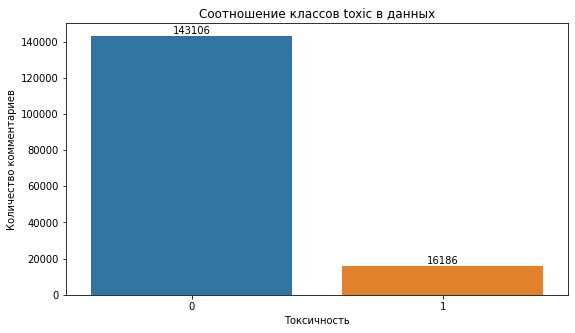

In [5]:
plt.figure(figsize=(9,5))
ax = sns.countplot(x=comments['toxic'])
ax.set_ylabel('Количество комментариев')
ax.set_xlabel('Токсичность')
ax.set_title('Соотношение классов toxic в данных')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

In [6]:
def obj_plotting(df, column, figsize=(9, 5)):
    
    df_name = [k for k, v in globals().items() if v is df][0]
    
    colors = ['#FFD1DC', '#E0F7FA']
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    df[column].value_counts().plot(
        kind='pie', 
        autopct='%1.1f%%',
        colors=colors,
        ax=ax,
        wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
        textprops={'fontsize': 10}
    )
    ax.set_title(f'Распределение {column}\n{df_name}', pad=20)
    ax.set_ylabel('')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nСтатистика для {df_name}:")
    print(df[column].value_counts())

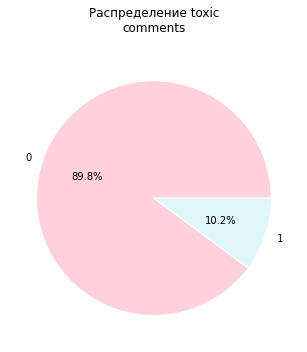


Статистика для comments:
0    143106
1     16186
Name: toxic, dtype: int64


In [7]:
obj_plotting(comments, 'toxic')

### Предобработка

In [8]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# стоп-слова
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def preprocessing(text):
    text_sub = re.sub(r"[^a-zA-Z ']", ' ', text)
    text = " ".join(text_sub.lower().split())
    tokens = word_tokenize(text)
    words = [word for word in tokens if word not in stop_words]
    words_lemm = [nlp(word)[0].lemma_ for word in words]
    text = " ".join(words_lemm)
    return text

In [10]:
comments['preproc'] = comments['text'].progress_apply(preprocessing)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [11]:
comments.head(10)

,text,toxic,preproc
0,Explanation\nWhy the edits made under my usern...,0,explanation edit make username hardcore metall...
1,D'aww! He matches this background colour I'm s...,0,d'aww match background colour ' seemingly stic...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man ' really try edit war be guy constantl...
3,"""\nMore\nI can't make any real suggestions on ...",0,can not make real suggestion improvement wonde...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page be
5,"""\n\nCongratulations from me as well, use the ...",0,congratulation well use tool well talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker piss around work
7,Your vandalism to the Matt Shirvington article...,0,vandalism matt shirvington article revert plea...
8,Sorry if the word 'nonsense' was offensive to ...,0,sorry word ' ' offensive anyway ' intend write...
9,alignment on this subject and which are contra...,0,alignment subject contrary dulithgow


### Разделение на выборки

In [12]:
df = comments.copy()

In [13]:
RANDOM_STATE = 42
X = df.drop(['toxic'], axis=1)
y = df['toxic']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE, test_size=0.1, stratify = y)

### Вывод по шагу 1

- В данных 159292 строки и 2 столбца: `text` с описанием товара и целевой признак - `toxic` - с классификацией текста по позитивности. Данные имеют корректные типы, названия столбцов соответствуют нормам. Пропуски и явные дубликаты отсутствуют;
- В имеющихся данных 143106 нетоксичных комментария (89.8%) и 16168 токсичных (10.2%)
- Данные в стобце `text` приведены к нижнему регистру, сохранены только латинские символы и пробелы. Выполнена токенизация и лемматизация, удалены стоп-слова. Предобработанные данные сохранены в столбце `preproc`;
- Данные разделены на тренировочные и тестовые в соотношении 1:3 с сохранением попорциональности классов по тональности текста.

## 2. Обучение

In [14]:
pipeline = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=stop_words, min_df = 1)),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [None, 5, 10, 20],
        'models__min_samples_split': [2, 5, 10],
        'models__min_samples_leaf': [1, 2, 4],
    },
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(penalty='l2', random_state=RANDOM_STATE)],
        'models__C': [0.2, 1, 10, 25],
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'models__kernel': ['rbf', 'linear'],
        'models__C': [0.1, 1, 10],
    }
]

In [15]:
randomized_search = RandomizedSearchCV(
    pipeline, 
    param_grid,
    n_iter=5,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    random_state=RANDOM_STATE
)
randomized_search.fit(X_train['preproc'], y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика F1 лучшей модели на кросс-валидации:', randomized_search.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Лучшая модель и её параметры:

 Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'ain', 'all',
                                             'am', 'an', 'and', 'any', 'are',
                                             'aren', "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             'couldn', "couldn't", ...})),
                ('models', SVC(C=10, random_state=42))])
Метрика F1 лучшей модели на кросс-валидации: 0.7739238563357475


In [16]:
# лучшая модель
model_best = randomized_search.best_estimator_

### Тестирование лучшей модели

In [17]:
# предсказания лучшей модели
predictions_test = model_best.predict(X_test['preproc'])

In [18]:
f1_test = f1_score(y_test, predictions_test)
print('F1 лучшей модели на тестовых данных =', round(f1_test, 2))

F1 лучшей модели на тестовых данных = 0.79


### Вывод по шагу 2

- Выполнен подбор оптимальной модели машинного обучения с подбором гиперпараметров. Протестированы следующие модели: DecisionTreeClassifier, LogisticRegression и SVC;
- Наилучшую метрику F1 на кросс-валидации показала модель `SVC(C=10)`. F1 лучшей модели при кросс-валидации составила 0.77;
- Качество лучшей модели было проверено на тестовых данных. F1 на тестовых данных равно 0.79, что удовлетворяет заявленным требованиям F1 > 0.75.

## 3. Выводы

- Данные успешно загружены и предобработаны. Выполнен анализ и предобработка данных. Выполнена токенизация и лемматизация, все тексты приведены к нижнему регистр и избавлены от стоп-слов. Данные подготовлены для обучения моделей.
- Выполнен подбор оптимальной модели машинного обучения с подбором гиперпараметров. Протестированы следующие модели: DecisionTreeClassifier, LogisticRegression и SVC;
- Наилучшую метрику F1 на кросс-валидации показала модель `SVC(C=10)`. F1 лучшей модели при кросс-валидации составила 0.77;
- Качество лучшей модели было проверено на тестовых данных. F1 на тестовых данных равно 0.79, что удовлетворяет заявленным требованиям F1 > 0.75.

Таким образом, была обучена и проверена оптимальная модель для решения поставленной задачи - определения тональности описания товара на сайте.